In [1]:
#Set google drive
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
#Install miniconda and rdkit
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2019-12-31 12:02:56--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71785000 (68M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  68.46M   255MB/s    in 0.3s    

2019-12-31 12:02:57 (255 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [71785000/71785000]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.2.0=py37_0
    - ca-certificates==2019.10.16=0
    - certifi==2019.9.11=py37_0
    - cffi==1.13.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b6447c_0
  

In [3]:
#Read smiles files
with open('/content/gdrive/My Drive/Colab Notebooks/smiles.txt') as f:
  smiles = f.readlines()[:]
  smiles = [s.strip() for s in smiles]
  smiles = [s.split()[1] for s in smiles]
print (len(smiles))
print (smiles[:10])

482852
['O=[N+]([O-])c1ccc(O)c(/C=N/c2ccc3nccnc3c2)c1', 'CCOC(=O)C1CCCNC1=O', 'C/C(=N/O)C1=CC(C)(C)CCC1', 'Cc1cc(N/N=C/c2cccc([N+](=O)[O-])c2)nc(-n2nc(C)cc2C)n1', 'CCOc1ccc(C2NC(=O)NC(C)=C2C(=O)OCc2ccccc2)cc1', 'CC(/C=C/c1ccc2c3c(cccc13)CC2)=C\\C(=O)[O-].[Na+]', 'CC1(C)Cc2ccccc2/C(=C/C(=O)Nc2ccccc2[N+](=O)[O-])N1', 'Cc1cc(C)c(NC(=O)/C=C2\\NC(C)(C)Cc3ccccc32)c(C)c1.Cl', 'Cn1c(=O)c(C(=O)Nc2ccncc2)c(O)c2ccccc21', 'Cc1cc(O)nc(N2CCCCC2)n1']


In [4]:
#Calculate Morgan fingerprints and LogP of each molecule
from rdkit import Chem
from rdkit.Chem.Crippen import MolLogP
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import numpy as np
import torch
import time

X, Y = [], []
num_data = 20000
st = time.time()
for s in smiles[:num_data]:
  m = Chem.MolFromSmiles(s)
  fp = np.array(AllChem.GetMorganFingerprintAsBitVect(m,2, nBits=1024))
  logp = MolLogP(m)
  X.append(fp)
  Y.append(logp)
end = time.time()

#Convert to torch tensor
X = torch.from_numpy(np.array(X)).float()
Y = torch.from_numpy(np.array(Y)).float()

print (X.size())
print (Y.size())
print (f'Time:{(end-st):.3f}')

torch.Size([20000, 1024])
torch.Size([20000])
Time:52.835


In [5]:
#Divide training and test data
num_train = 19000
X_train = X[:num_train, :]
Y_train = Y[:num_train]
X_test = X[num_train:]
Y_test = Y[num_train:]

print (X_train.size())
print (f'Num train data: {len(X_train)}')
print (f'Num test data: {len(X_test)}')


torch.Size([19000, 1024])
Num train data: 19000
Num test data: 1000


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LinearRegressor(torch.nn.Module):
  def __init__(self, D_in, D_out, H):
    super(LinearRegressor, self).__init__()
    self.linear1 = nn.Linear(D_in, H)
    self.linear2 = nn.Linear(H, H)
    self.linear3 = nn.Linear(H, D_out)

  def forward(self, x):
    retval = self.linear1(x)
    retval = F.tanh(retval)
    retval = self.linear2(retval)
    retval = F.tanh(retval)
    retval = self.linear3(retval)
    return retval

In [9]:
#Train model
import time
lr = 1e-6
model = LinearRegressor(1024,1, 1024)

#Load model
#model.load_state_dict(torch.load(fn))

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)

loss_fn = nn.MSELoss()
batch_size = 512
loss_list = []
st = time.time()

X_train = X_train.cuda()
Y_train = Y_train.cuda()
X_test = X_test.cuda()
Y_test = Y_test.cuda()
model = model.cuda()

for i in range(20001):
  idx = torch.randint(0, len(X_train), (batch_size,))
  x = X_train[idx,:]
  y = Y_train[idx]

  pred = model(x)
  pred = pred.squeeze(-1)
  loss = loss_fn(pred, y)
  loss.backward()
  optimizer.step()
  loss_list.append(loss.data.cpu().numpy())
  if i%1000==0:
    print (i, loss.data.cpu().numpy())
end = time.time()
print ('Time:', end-st)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


0 14.234811
1000 3.9986713
2000 4.916071
3000 2.9873538
4000 1.5919942
5000 1.5328112
6000 1.6076306
7000 1.2913125
8000 1.2885585
9000 1.0342262
10000 0.9680004
11000 1.024048
12000 0.9014702
13000 0.8129315
14000 0.984004
15000 0.9324311
16000 0.8575953
17000 1.1984792
18000 0.9879315
19000 0.87159866
20000 1.1692955
Time: 39.33313965797424


In [0]:
#Save model
fn = '/content/gdrive/My Drive/save.pt'
torch.save(model.state_dict(), fn)

In [11]:
#Load model
model.load_state_dict(torch.load(fn))

<All keys matched successfully>

Text(0, 0.5, 'Loss')

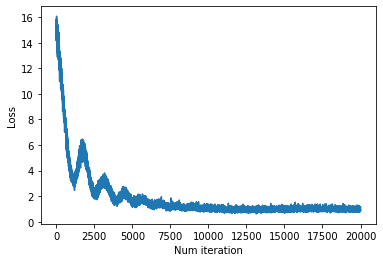

In [12]:
import matplotlib.pyplot as plt

plt.plot(loss_list)
plt.xlabel('Num iteration')
plt.ylabel('Loss')


In [13]:
#Test model
model.eval()
with torch.no_grad():
  y_pred_train = model(X_train).squeeze(-1)
  y_pred_test = model(X_test).squeeze(-1)

loss_train = loss_fn(Y_train, y_pred_train)
loss_test = loss_fn(Y_test, y_pred_test)

print ('Train loss:', loss_train.data.cpu().numpy())
print ('Test loss:', loss_test.data.cpu().numpy())

Train loss: 0.9361122
Test loss: 1.0068752


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Text(0, 0.5, 'Pred')

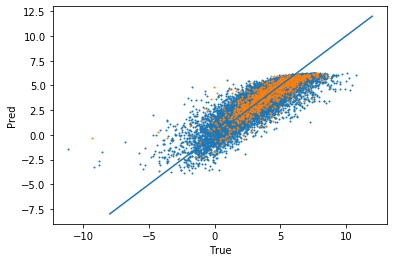

In [14]:

plt.scatter(Y_train.data.cpu().numpy(), y_pred_train.data.cpu().numpy(), s=1)
plt.scatter(Y_test.data.cpu().numpy(), y_pred_test.data.cpu().numpy(), s=1)
plt.plot([-8,12], [-8,12])
plt.xlabel('True')
plt.ylabel('Pred')
